In [4]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Dataset "__bikes_rent.csv__": calendar information and weather conditions for automated bike rental points, as well as the number of rentals that day. We need to predict the number of rentals.

In [5]:
df = pd.read_csv('bikes_rent.csv')
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Some explanations:

* *season*: 1 - spring, 2 - summer, etc.
* *yr*: 0 - 2011, 1 - 2012
* *weathersit*: 1 - clear day, 4 - heavy rain, fog
* *atemp*: apparent temperature
* *cnt*: number of rented bicycles

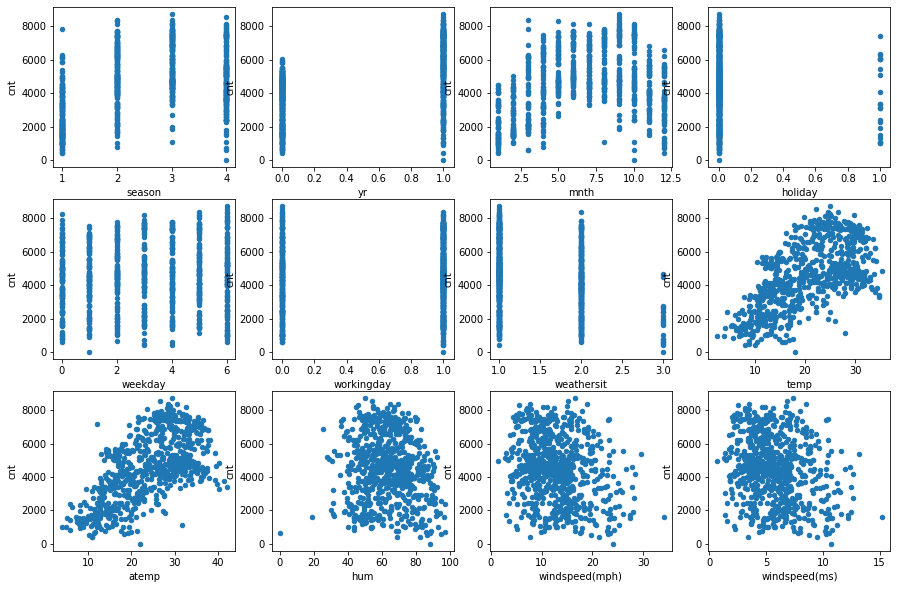

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

In [7]:
# calculating Pearson's correlation
df.iloc[:, :-1].corrwith(df.cnt)

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

In [8]:
paircorr = ['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']
df[paircorr].corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


There are two pairs of strongly correlated columns in the matrix: temp and atemp, windspeed (mph/ms)

In [9]:
df.mean()

season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64

In [14]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

# scaling and shuffling
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

In [15]:
from sklearn.linear_model import LinearRegression

# creating and fitting regression
lr_model = LinearRegression()
lr_model.fit(X, y)

# printing weights
for i in zip(df_shuffled.columns[:-1], lr_model.coef_.round(1)):
    print(i)

('season', 570.9)
('yr', 1022.0)
('mnth', -141.3)
('holiday', -86.8)
('weekday', 137.2)
('workingday', 56.4)
('weathersit', -330.2)
('temp', 367.5)
('atemp', 585.6)
('hum', -145.6)
('windspeed(mph)', 12457576985764.6)
('windspeed(ms)', -12457576985963.0)


The weights for linearly dependent features are significantly greater than for other ones.

In [19]:
# regularization

from sklearn.linear_model import Lasso, Ridge

# fitting L1
L1 = Lasso()
L1.fit(X, y)

# printing weights
for i in zip(df_shuffled.columns[:-1], L1.coef_.round(1)):
    print(i)

('season', 560.2)
('yr', 1019.5)
('mnth', -128.7)
('holiday', -86.2)
('weekday', 137.3)
('workingday', 55.2)
('weathersit', -332.4)
('temp', 376.4)
('atemp', 576.5)
('hum', -144.1)
('windspeed(mph)', -197.1)
('windspeed(ms)', -0.0)


In [20]:
# fitting L2
L2 = Ridge()
L2.fit(X, y)

# printing weights
for i in zip(df_shuffled.columns[:-1], L2.coef_.round(1)):
    print(i)

('season', 563.1)
('yr', 1018.9)
('mnth', -131.9)
('holiday', -86.7)
('weekday', 138.0)
('workingday', 55.9)
('weathersit', -332.3)
('temp', 386.5)
('atemp', 566.3)
('hum', -145.1)
('windspeed(mph)', -99.3)
('windspeed(ms)', -99.3)


L1 zeroes weights for some features.

Text(0.5, 1.0, 'Ridge')

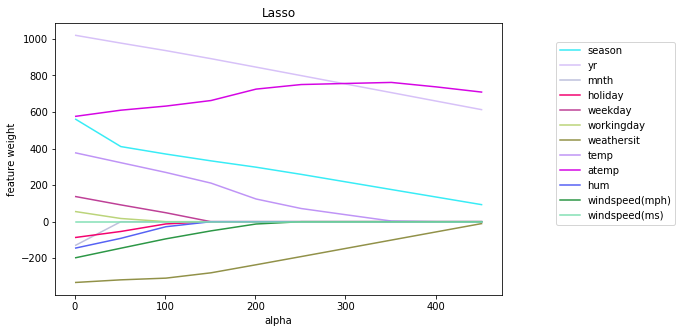

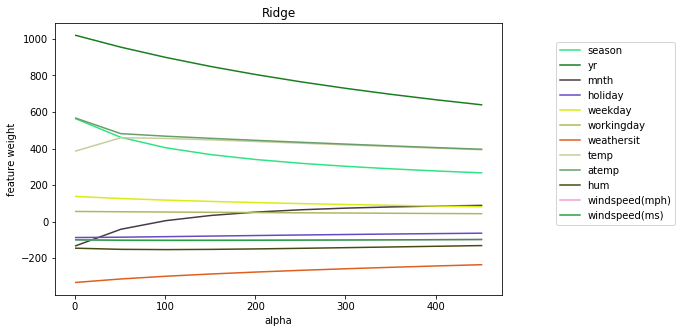

In [22]:
# increasing the regularization coefficient

alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # matrix of weights
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))


for index, item in enumerate(alphas):
    
    l1 = Lasso(alpha=alphas[index])
    l1.fit(X, y)
    coefs_lasso[index] = l1.coef_
    
    l2 = Ridge(alpha=alphas[index])
    l2.fit(X, y)
    coefs_ridge[index] = l2.coef_
    

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

![](https://www.astroml.org/_images_1ed/fig_lasso_ridge_1.png)

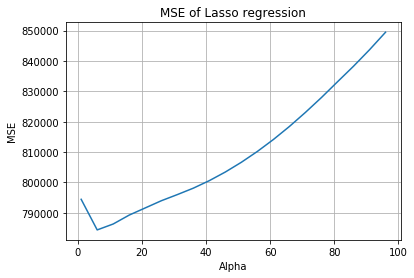

('season', 532.0)
('yr', 1015.1)
('mnth', -100.0)
('holiday', -83.3)
('weekday', 132.5)
('workingday', 51.6)
('weathersit', -330.6)
('temp', 370.7)
('atemp', 581.4)
('hum', -140.0)
('windspeed(mph)', -191.8)
('windspeed(ms)', -0.0)


In [23]:
# using cross-validation
from sklearn.linear_model import LassoCV

# fitting on different alphas
alphas = np.arange(1, 100, 5) 
cv_l1 = LassoCV(alphas=alphas)
cv_l1.fit(X, y)

# plotting
plt.title('MSE of Lasso regression')
plt.plot(cv_l1.alphas_, np.mean(cv_l1.mse_path_, axis=1))
plt.xlabel('Alpha')
plt.ylabel('MSE')
plt.grid()
plt.show()

# printing feature-coefficient pairs
for i in zip(df_shuffled.columns[:-1], cv_l1.coef_.round(1)):
    print(i)

__alpha = 6__

Let's see which alphas we would choose if we split the sample only once.

MSE mins for every split: [6 1 6 1 1]


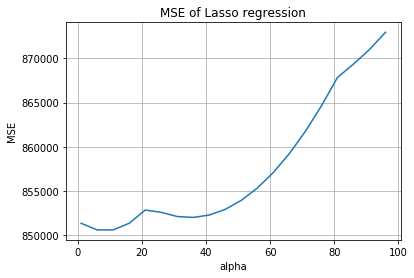

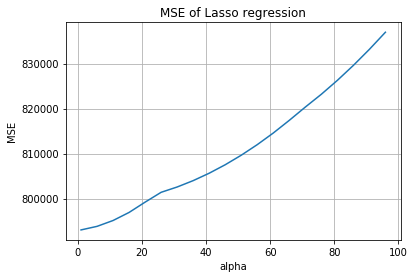

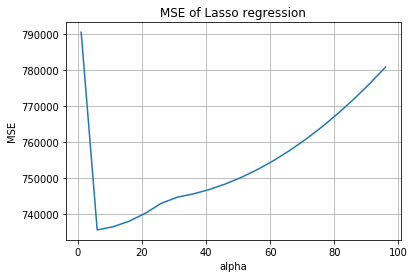

In [25]:
print('MSE mins for every split:', cv_l1.alphas_[np.argmin(cv_l1.mse_path_, axis = 0)])

# visualizing .mse_path_ columns
for i in range(3):
    plt.plot(cv_l1.alphas_, cv_l1.mse_path_[:, i])
    plt.xlabel('alpha')
    plt.ylabel('MSE')
    plt.title('MSE of Lasso regression')
    plt.grid()
    plt.show()

Each split has a different optimal alpha value.